<font size="+3">Time-series Generative Adversarial Network (TimeGAN)</font>

# Introduction

The material is based on the 2<sup>nd</sup> edition of my book on [Machine Learning for Trading]((https://www.amazon.com/Machine-Learning-Algorithmic-Trading-alternative/dp/1839217715?pf_rd_r=GZH2XZ35GB3BET09PCCA&pf_rd_p=c5b6893a-24f2-4a59-9d4b-aff5065c90ec&pd_rd_r=91a679c7-f069-4a6e-bdbb-a2b3f548f0c8&pd_rd_w=2B0Q0&pd_rd_wg=GMY5S&ref_=pd_gw_ci_mcx_mr_hp_d)) (see [GitHub repo](https://github.com/stefan-jansen/machine-learning-for-trading)).

Generating synthetic time-series data poses specific challenges above and beyond those encountered when designing GANs for images. In addition to the distribution over variables at any given point, such as pixel values or the prices of numerous stocks, a generative model for time-series data should also learn the temporal dynamics that shapes how one sequence of observations follows another (see also discussion in [Chapter 9: Time Series Models for Volatility Forecasts and Statistical Arbitrage](https://github.com/stefan-jansen/machine-learning-for-trading/tree/master/09_time_series_models)).

Very recent and promising [research]((https://proceedings.neurips.cc/paper/2019/file/c9efe5f26cd17ba6216bbe2a7d26d490-Paper.pdf)) by Yoon, Jarrett, and van der Schaar, presented at NeurIPS in December 2019, introduces a novel Time-Series Generative Adversarial Network (**TimeGAN**) framework that aims to account for temporal correlations by combining supervised and unsupervised training. The model learns a time-series embedding space while optimizing both supervised and adversarial objectives that encourage it to adhere to the dynamics observed while sampling from historical data during training. The authors test the model on various time series, including historical stock prices, and find that the quality of the synthetic data significantly outperforms that of available alternatives.

Adapted from the excellent paper by Jinsung Yoon, Daniel Jarrett, and Mihaela van der Schaar:  
[Time-series Generative Adversarial Networks](https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks),  
Neural Information Processing Systems (NeurIPS), 2019.

- Last updated Date: April 24th 2020
- [Original code](https://bitbucket.org/mvdschaar/mlforhealthlabpub/src/master/alg/timegan/) author: Jinsung Yoon (jsyoon0823@gmail.com)

We outline how this sophisticated model works, highlight key implementation steps that build on the [DCGAN](https://github.com/stefan-jansen/machine-learning-for-trading/blob/master/21_gans_for_synthetic_time_series/01_deep_convolutional_generative_adversarial_network.ipynb) example, and show how to evaluate the quality of the resulting time series. Please see the paper for additional information.

# Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [4]:
sns.set_style('white')

In [5]:
np.random.seed(42)
tf.random.set_seed(1234)

## Experiment Path

In [6]:
results_path = Path('time_gan')
if not results_path.exists():
    results_path.mkdir()

In [7]:
experiment = 0

In [8]:
log_dir = results_path / f'experiment_{experiment:02}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

In [9]:
hdf_store = results_path / 'TimeSeriesGAN.h5'

# TimeGAN Architecture and Training

## Learning the data generation process across features and time
A successful generative model for time-series data needs to capture both the cross-sectional distribution of features at each point in time and the longitudinal relationships among these features over time. Expressed in the image context we just discussed, the model needs to learn not only what a realistic image looks like, but also how one image evolves from the next as in a video.

## Combining adversarial and supervised training with time-series embedding

Prior attempts at generating time-series data like the recurrent (conditional) GAN relied on recurrent neural networks (RNN, see [Chapter 19, RNN for Multivariate Time Series and Sentiment Analysis](https://github.com/stefan-jansen/machine-learning-for-trading/tree/master/19_recurrent_neural_nets)) in the roles of generator and discriminator. TimeGAN explicitly incorporates the autoregressive nature of time series by combining the unsupervised adversarial loss on both real and synthetic sequences familiar from the DCGAN example with a stepwise supervised loss with respect to the original data. The goal is to reward the model for learning the distribution over transitions from one point in time to the next present in the historical data.

Furthermore, TimeGAN includes an embedding network that maps the time-series features to a lower-dimensional latent space to reduce the complexity of the adversarial space. The motivation is to capture the drivers of temporal dynamics that often have lower dimensionality (see also the discussions of manifold learning in [Chapter 13](https://github.com/stefan-jansen/machine-learning-for-trading/tree/master/13_unsupervised_learning) and nonlinear dimensionality reduction in [Chapter 20](https://github.com/stefan-jansen/machine-learning-for-trading/tree/master/20_autoencoders_for_conditional_risk_factors)). 

A **key element** of the TimeGAN architecture is that both the generator and the embedding (or autoencoder) network are responsible for minimizing the supervised loss that measures how well the model learns the dynamic relationship. 

As a result, the model learns a latent space conditioned on facilitating the generator’s task to faithfully reproduce the temporal relationships observed in the historical data. In addition to time-series data, the model can also process *static* data that do not change or change less frequently over time.

The design of the TimeGAN components follows the author's sample code.

## The four components of the TimeGAN architecture
The TimeGAN architecture combines an adversarial network with an autoencoder and has thus **four network components** as depicted in the below Figure:
- **Autoencoder**: embedding and recovery networks
- **Adversarial Network**: sequence generator and sequence discriminator components

<img src="https://i.imgur.com/2QurkKl.png" title="source: imgur.com" width="600"/>

The **embedding and recovery components** of the autoencoder map the feature space into the latent space and vice versa to facilitate the learning of the temporal dynamics by the adversarial network learns in a lower-dimensional space. The authors implement the embedding and recovery network using a stacked RNN and a feedforward network. However, these choices can be flexibly adapted to the task at hand as long as they are autoregressive and respect the temporal order of the data.

The **generator and discriminator elements** of the adversarial network differ from the DCGAN not only because they operate on sequential data but also because the synthetic features are generated in the latent space that the model learns simultaneously. The authors choose an RNN as generator and a bidirectional RNN with a feedforward output layer for the discriminator.

## Joint training of autoencoder and adversarial network
The three loss functions displayed in the Figure above drive the joint optimization of the network elements just described while training on real and randomly generated time series. In more detail, they aim to accomplish the following:
- The **reconstruction loss** is familiar from our discussion of autoencoders in [Chapter 20](https://github.com/stefan-jansen/machine-learning-for-trading/tree/master/20_autoencoders_for_conditional_risk_factors); it compares how well the reconstruction of the encoded data resembles the original. 
- The **unsupervised loss** reflects the competitive interaction between the generator and the discriminator described in the [DCGAN](https://github.com/stefan-jansen/machine-learning-for-trading/blob/master/21_gans_for_synthetic_time_series/01_deep_convolutional_generative_adversarial_network.ipynb) example; while the generator aims to minimize the probability that the discriminator classifies its output as fake, the discriminator aims to optimize the correct classification or real and fake inputs.
- The **supervised loss** captures how well the generator approximates the actual next time step in latent space when receiving encoded real data for the prior sequence.

As a result of the joint training, TimeGAN simultaneously learns to encode features, generate representations, and iterate across time. More specifically, the embedding network creates the latent space, the adversarial network operates within this space, and supervised loss synchronizes the latent dynamics of both real and synthetic data.

## Training in three phases

Training proceeds along the following three phases:
1. Train the autoencoder on real time series to optimize reconstruction
2. Optimize the supervised loss using real time series to capture the temporal dynamics of the historical data
3. Jointly train the four components while minimizing all three loss functions

TimeGAN includes several hyperparameters used to weigh the components of composite loss functions; however, the authors find the network to be less sensitive to these settings than one might expect given the notorious difficulties of GAN training. In fact, they do not discover significant challenges during training and suggest that the embedding task serves to regularize adversarial learning because it reduces its dimensionality while the supervised loss constrains the stepwise dynamics of the generator.

## TimeGAN with TensorFlow 2

We now turn to the TimeGAN implementation using TensorFlow 2; see the paper for an in-depth explanation of the math and methodology of the approach.

In the next sections, we'll implement the TimeGAN architecture just described. The authors provide sample code using TensorFlow 1 that we port to TensorFlow 2. Building and training TimeGAN requires several steps:
1. Selecting and preparing real and random time series inputs
2. Creating the key TimeGAN model components
3. Defining the various loss functions and train steps used during the three training phases
4. Running the training loops and logging the results
5. Generating synthetic time series and evaluating the results

We’ll walk through the key items for each of these steps; please refer to the notebook TimeGAN_TF2 for the code examples in this section (unless otherwise noted) as well as additional implementation details.

# Prepare Data

The authors demonstrate the applicability of TimeGAN to financial data using 15 years of daily Google stock prices downloaded from Yahoo Finance with six features, namely open, high, low, close and adjusted close price, and volume. We’ll use instead close to 20 years of adjusted close prices for six different tickers because it introduces somewhat higher variability. We follow the original paper in targeting synthetic series with 24 time steps. 

In [10]:
df = pd.read_csv('stocks.csv', 
                 index_col='date', 
                 parse_dates=['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4586 entries, 2000-01-03 to 2018-03-27
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BA      4586 non-null   float64
 1   CAT     4586 non-null   float64
 2   DIS     4586 non-null   float64
 3   GE      4586 non-null   float64
 4   IBM     4586 non-null   float64
 5   KO      4586 non-null   float64
dtypes: float64(6)
memory usage: 250.8 KB


## Parameters

In [11]:
seq_len = 24
n_seq = 6
batch_size = 128

In [12]:
tickers = ['BA', 'CAT', 'DIS', 'GE', 'IBM', 'KO']

## Plot Series

Among the stocks with the longest history in the Quandl Wiki dataset are those displayed in normalized format, i.e., starting at 1.0, in the following Figure 21.5. We retrieve the adjusted close from 2000-2017 and obtain over 4,000 observations. The correlation coefficient among the series ranges from 0.01 for GE and CAT. to 0.94 for DIS and KO.

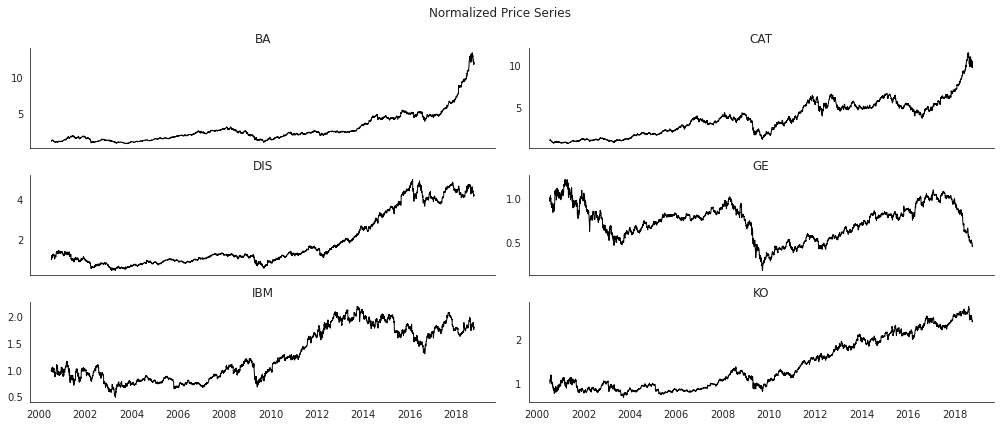

In [13]:
axes = df.div(df.iloc[0]).plot(subplots=True,
                               figsize=(14, 6),
                               layout=(3, 2),
                               title=tickers,
                               legend=False,
                               rot=0,
                               lw=1, 
                               color='k')
for ax in axes.flatten():
    ax.set_xlabel('')

plt.suptitle('Normalized Price Series')
plt.gcf().tight_layout()
sns.despine();

## Correlation

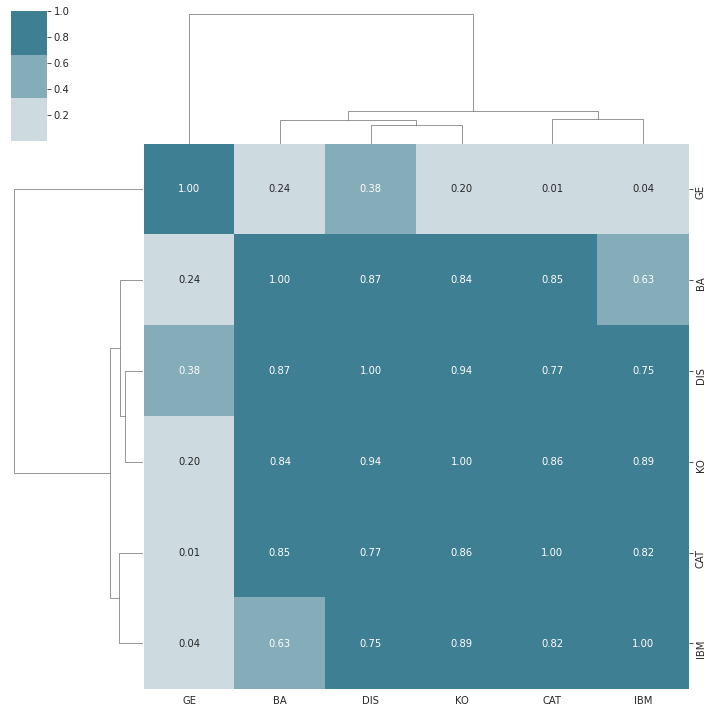

In [14]:
sns.clustermap(df.corr(),
               annot=True,
               fmt='.2f',
               cmap=sns.diverging_palette(h_neg=20,
                                          h_pos=220), center=0);

## Normalize Data

We scale each series to the range [0, 1] using scikit-learn’s `MinMaxScaler` that we later use to rescale the synthetic data.

In [15]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)

## Create rolling window sequences

In the next step, we create rolling windows containing overlapping sequences of 24 consecutive data points for the six series:

In [16]:
data = []
for i in range(len(df) - seq_len):
    data.append(scaled_data[i:i + seq_len])

n_windows = len(data)

## Create tf.data.Dataset

In [17]:
real_series = (tf.data.Dataset
               .from_tensor_slices(data)
               .shuffle(buffer_size=n_windows)
               .batch(batch_size))
real_series_iter = iter(real_series.repeat())

## Set up random series generator

We also need a random time series generator that produces simulated data with 24 observations on the six series as long as the training continues.

To this end, we create a generator that draws the requisite data uniform at random and feed the result into a second `tf.data.Dataset`. We set this `Dataset` to produce batches of the desired size and to repeat the process as long as necessary:

In [18]:
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

We use the Python generator to feed a `tf.data.Dataset` that continues to call the random number generator as long as necessary and produces the desired batch size.

In [19]:
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

# TimeGAN Setup

We’ll now create the two autoencoder components and the two adversarial network elements, as well as the supervisor that encourages the generator to learn the temporal dynamic of the historical price series.

##  Network Parameters

We follow the authors’ sample code in creating RNNs with three hidden layers with 24 GRU units each, except for the supervisor that only uses two hidden layers.

In [20]:
hidden_dim = 24
num_layers = 3

## Set up logger

In [21]:
writer = tf.summary.create_file_writer(log_dir.as_posix())

## Input place holders

In [22]:
X = Input(shape=[seq_len, n_seq], name='RealData')
Z = Input(shape=[seq_len, n_seq], name='RandomData')

## RNN block generator

We keep it simple and use a very similar architecture for all four components. For a real-world application, they should be tailored to the data.

The following `make_rnn` function automates the network creation:

In [23]:
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units,
                           return_sequences=True,
                           name=f'GRU_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units,
                             activation='sigmoid',
                             name='OUT')], name=name)

## Embedder & Recovery

The autoencoder consists of the embedder and the recovery networks that we instantiate here:

In [24]:
embedder = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=hidden_dim, 
                    name='Embedder')
recovery = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=n_seq, 
                    name='Recovery')

## Generator & Discriminator

We then create the generator, the discriminator, and the supervisor like so:

In [25]:
generator = make_rnn(n_layers=3, 
                     hidden_units=hidden_dim, 
                     output_units=hidden_dim, 
                     name='Generator')
discriminator = make_rnn(n_layers=3, 
                         hidden_units=hidden_dim, 
                         output_units=1, 
                         name='Discriminator')
supervisor = make_rnn(n_layers=2, 
                      hidden_units=hidden_dim, 
                      output_units=hidden_dim, 
                      name='Supervisor')

# TimeGAN Training

## Settings

In [26]:
train_steps = 10000
gamma = 1

## Generic Loss Functions

We also define two generic loss functions, namely `MeanSquaredError` and `BinaryCrossEntropy` that we will use later to create the various specific loss functions during the three phases:

In [27]:
mse = MeanSquaredError()
bce = BinaryCrossentropy()

# Phase 1: Autoencoder Training

## Architecture

The autoencoder integrates the embedder and the recovery functions:

In [28]:
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X,
                    outputs=X_tilde,
                    name='Autoencoder')

In [29]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RealData (InputLayer)        [(None, 24, 6)]           0         
_________________________________________________________________
Embedder (Sequential)        (None, 24, 24)            10104     
_________________________________________________________________
Recovery (Sequential)        (None, 24, 6)             10950     
Total params: 21,054
Trainable params: 21,054
Non-trainable params: 0
_________________________________________________________________


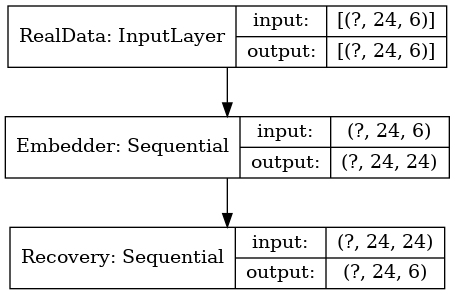

In [30]:
plot_model(autoencoder,
           to_file=(results_path / 'autoencoder.png').as_posix(),
           show_shapes=True)

We next instantiate the optimizer for this training phase and define the training step. It follows the pattern introduced with the DCGAN example, using tf.GradientTape to record the operations that generate the reconstruction loss. This allows us to rely on the automatic differentiation engine to obtain the gradients with respect to the trainable embedder and recovery network weights that drive backpropagation:

## Autoencoder Optimizer

In [31]:
autoencoder_optimizer = Adam()

## Autoencoder Training Step

In [32]:
@tf.function
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

## Autoencoder Training Loop

The reconstruction loss simply compares the autoencoder outputs with its inputs. We train for 10,000 steps in a little over one minute using this training loop that records the step loss for monitoring with TensorBoard:

In [33]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)

100%|██████████| 10000/10000 [01:21<00:00, 122.49it/s]


## Persist model

In [34]:
# autoencoder.save(log_dir / 'autoencoder')

# Phase 2: Supervised training

We already created the supervisor model so we just need to instantiate the optimizer and define the train step as follows:

## Define Optimizer

In [35]:
supervisor_optimizer = Adam()

## Train Step

In [36]:
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

In this case, the loss compares the output of the supervisor with the next timestep for the embedded sequence so that it learns the temporal dynamics of the historical price sequences; the training loop works similarly to the autoencoder example.

## Training Loop

In [37]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

100%|██████████| 10000/10000 [03:08<00:00, 52.96it/s]


## Persist Model

In [38]:
# supervisor.save(log_dir / 'supervisor')

# Joint Training

The joint training involves all four network components as well as the supervisor. It uses multiple loss functions and combinations of the base components to achieve the simultaneous learning of latent space embeddings, transition dynamics, and synthetic data generation. 

## Generator

### Adversarial Architecture - Supervised

In [39]:
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(inputs=Z,
                               outputs=Y_fake,
                               name='AdversarialNetSupervised')

In [40]:
adversarial_supervised.summary()

Model: "AdversarialNetSupervised"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RandomData (InputLayer)      [(None, 24, 6)]           0         
_________________________________________________________________
Generator (Sequential)       (None, 24, 24)            10104     
_________________________________________________________________
Supervisor (Sequential)      (None, 24, 24)            7800      
_________________________________________________________________
Discriminator (Sequential)   (None, 24, 1)             10825     
Total params: 28,729
Trainable params: 28,729
Non-trainable params: 0
_________________________________________________________________


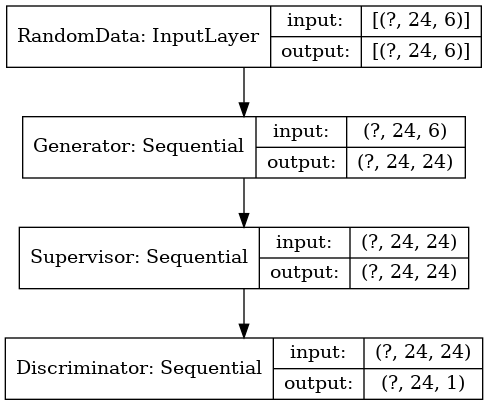

In [41]:
plot_model(adversarial_supervised, show_shapes=True)

### Adversarial Architecture in Latent Space

In [42]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z,
                    outputs=Y_fake_e,
                    name='AdversarialNet')

In [43]:
adversarial_emb.summary()

Model: "AdversarialNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RandomData (InputLayer)      [(None, 24, 6)]           0         
_________________________________________________________________
Generator (Sequential)       (None, 24, 24)            10104     
_________________________________________________________________
Discriminator (Sequential)   (None, 24, 1)             10825     
Total params: 20,929
Trainable params: 20,929
Non-trainable params: 0
_________________________________________________________________


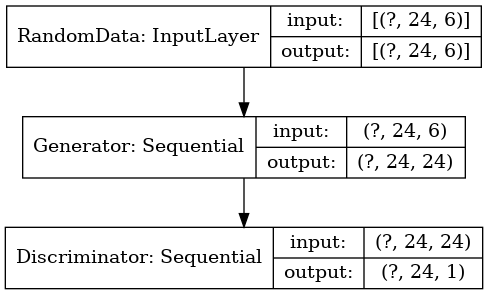

In [44]:
plot_model(adversarial_emb, show_shapes=True)

### Mean & Variance Loss

To ensure that the generator faithfully reproduces the time series, TimeGAN includes a moment loss that penalizes when mean and variance of the synthetic data deviate from the real version:

In [45]:
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z,
                       outputs=X_hat,
                       name='SyntheticData')

The end-to-end model that produces synthetic data involves the generator, supervisor, and recovery component. It is defined as follows and has close to 30,000 trainable paramters:

In [46]:
synthetic_data.summary()

Model: "SyntheticData"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RandomData (InputLayer)      [(None, 24, 6)]           0         
_________________________________________________________________
Generator (Sequential)       (None, 24, 24)            10104     
_________________________________________________________________
Supervisor (Sequential)      (None, 24, 24)            7800      
_________________________________________________________________
Recovery (Sequential)        (None, 24, 6)             10950     
Total params: 28,854
Trainable params: 28,854
Non-trainable params: 0
_________________________________________________________________


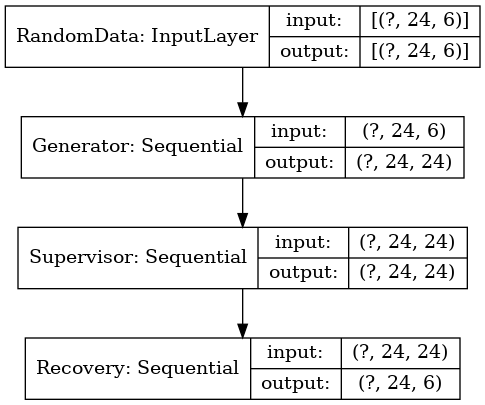

In [47]:
plot_model(synthetic_data, show_shapes=True)

In [48]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

## Discriminator

### Architecture: Real Data

In [49]:
Y_real = discriminator(H)
discriminator_model = Model(inputs=X,
                            outputs=Y_real,
                            name='DiscriminatorReal')

In [50]:
discriminator_model.summary()

Model: "DiscriminatorReal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RealData (InputLayer)        [(None, 24, 6)]           0         
_________________________________________________________________
Embedder (Sequential)        (None, 24, 24)            10104     
_________________________________________________________________
Discriminator (Sequential)   (None, 24, 1)             10825     
Total params: 20,929
Trainable params: 20,929
Non-trainable params: 0
_________________________________________________________________


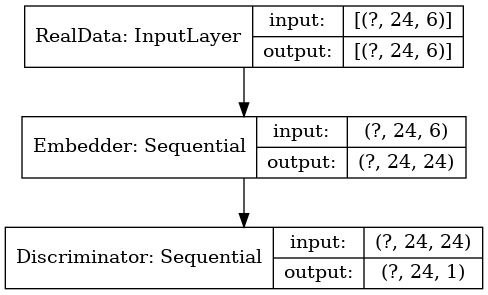

In [51]:
plot_model(discriminator_model, show_shapes=True)

## Optimizers

The joint training involves three optimizers for the autoencoder, the generator and the discriminator:

In [52]:
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

## Generator Train Step

The train step for the generator illustrates the use of four loss functions and corresponding combinations of network components to achieve the desired learning outlined at the beginning of this section:

In [53]:
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),
                                          y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),
                                            y_pred=y_fake_e)
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (generator_loss_unsupervised +
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

## Embedding Train Step

In [54]:
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

## Discriminator Train Step

In [55]:
@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

In [56]:
@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

## Training Loop

Finally, the joint training loop pulls the various training steps together and builds on the learning from phase 1 and 2 to train the TimeGAN components on both real and random data. We run the loop for 10,000 iterations in under 50 minutes:

In [57]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(real_series_iter)
        Z_ = next(random_series)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(real_series_iter)
    Z_ = next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 1000 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)

     0 | d_loss: 2.1403 | g_loss_u: 0.6477 | g_loss_s: 0.0004 | g_loss_v: 0.3361 | e_loss_t0: 0.0478
 1,000 | d_loss: 1.5376 | g_loss_u: 1.1695 | g_loss_s: 0.0001 | g_loss_v: 0.0521 | e_loss_t0: 0.0152
 2,000 | d_loss: 1.7096 | g_loss_u: 1.2424 | g_loss_s: 0.0001 | g_loss_v: 0.0275 | e_loss_t0: 0.0135
 3,000 | d_loss: 1.6910 | g_loss_u: 1.1935 | g_loss_s: 0.0001 | g_loss_v: 0.0185 | e_loss_t0: 0.0127
 4,000 | d_loss: 1.5217 | g_loss_u: 1.1806 | g_loss_s: 0.0001 | g_loss_v: 0.0587 | e_loss_t0: 0.0118
 5,000 | d_loss: 1.6148 | g_loss_u: 1.3036 | g_loss_s: 0.0001 | g_loss_v: 0.0209 | e_loss_t0: 0.0107
 6,000 | d_loss: 1.6404 | g_loss_u: 1.2828 | g_loss_s: 0.0001 | g_loss_v: 0.0266 | e_loss_t0: 0.0102
 7,000 | d_loss: 1.5307 | g_loss_u: 1.4742 | g_loss_s: 0.0001 | g_loss_v: 0.0365 | e_loss_t0: 0.0102
 8,000 | d_loss: 1.5038 | g_loss_u: 1.5569 | g_loss_s: 0.0001 | g_loss_v: 0.0705 | e_loss_t0: 0.0086
 9,000 | d_loss: 1.3065 | g_loss_u: 1.4653 | g_loss_s: 0.0001 | g_loss_v: 0.0393 | e_loss_t

## Persist Synthetic Data Generator

In [58]:
synthetic_data.save(log_dir / 'synthetic_data')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: time_gan/experiment_00/synthetic_data/assets


# Generate Synthetic Data

To evaluate the TimeGAN results, we generate synthetic by drawing random inputs and feeding them to the `synthetic_data` network just described. 

More specifically, we’ll create roughly as many artificial series with 24 observations on the six tickers as there are overlapping windows in the real dataset:

In [59]:
generated_data = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data.append(d)

In [60]:
len(generated_data)

35

The result is 35 batches containing 128 samples with dimensions 24⨉6 each that we stack like so:

In [61]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape

(4480, 24, 6)

In [62]:
np.save(log_dir / 'generated_data.npy', generated_data)

## Rescale

We can use the trained MinMaxScaler to revert the synthetic to the scale of the input series:

In [63]:
generated_data = (scaler.inverse_transform(generated_data
                                           .reshape(-1, n_seq))
                  .reshape(-1, seq_len, n_seq))
generated_data.shape

(4480, 24, 6)

## Persist Data

In [64]:
with pd.HDFStore(hdf_store) as store:
    store.put('data/synthetic', pd.DataFrame(generated_data.reshape(-1, n_seq),
                                             columns=tickers))

## Plot sample Series

The below figure displays samples of the six synthetic series and the corresponding real series. The synthetic data generally reflect a variation of behavior not unlike their real counterparts and, after rescaling, roughly (due to the random input) match their range.

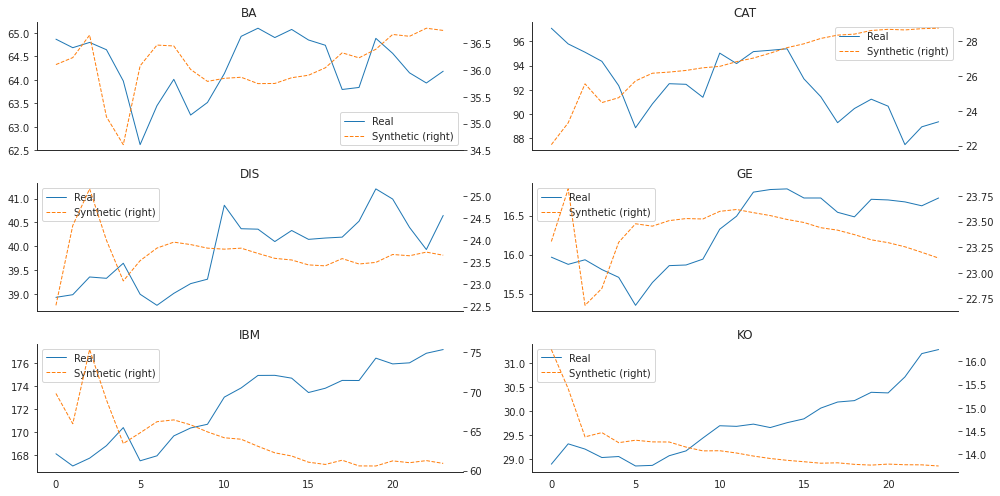

In [73]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 7))
axes = axes.flatten()

index = list(range(1, 25))
synthetic = generated_data[np.random.randint(n_windows)]

idx = np.random.randint(len(df) - seq_len)
real = df.iloc[idx: idx + seq_len]

for j, ticker in enumerate(tickers):
    (pd.DataFrame({'Real': real.iloc[:, j].values,
                   'Synthetic': synthetic[:, j]})
     .plot(ax=axes[j],
           title=ticker,
           secondary_y='Synthetic', style=['-', '--'],
           lw=1))
sns.despine()
fig.tight_layout()